<a href="https://colab.research.google.com/github/Hayjaycodes/Customer-Sign-Up-Behaviour-Data-Quality-Audit/blob/main/Data_Analysis_ForBusinessInsight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Customer Sign-Up Behaviour & Data Quality Audit

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/customer_signups.csv")

In [ ]:
# Check structure
print("Shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nFirst 5 rows:\n", df.head())

Shape: (300, 10)

Data types:
 customer_id         object
name                object
email               object
signup_date         object
source              object
region              object
plan_selected       object
marketing_opt_in    object
age                 object
gender              object
dtype: object

First 5 rows:
   customer_id             name                 email signup_date     source  \
0   CUST00000    Joshua Bryant                   NaN         NaN  Instagram   
1   CUST00001   Nicole Stewart   nicole1@example.com    02-01-24   LinkedIn   
2   CUST00002     Rachel Allen   rachel2@example.com    03-01-24     Google   
3   CUST00003  Zachary Sanchez  zachary3@mailhub.org    04-01-24    YouTube   
4   CUST00004              NaN  matthew4@mailhub.org    05-01-24   LinkedIn   

  region plan_selected marketing_opt_in age      gender  
0    NaN         basic               No  34      Female  
1   West         basic              Yes  29        Male  
2  North       PREMI

In [ ]:
# 2. Identify Missing Values
# -----------------------------
missing = df.isna().sum().to_frame("Missing")
missing["% Missing"] = (missing["Missing"] / len(df) * 100).round(2)
print("\nMissing Values:\n", missing)



Missing Values:
                   Missing  % Missing
customer_id             2       0.67
name                    9       3.00
email                  34      11.33
signup_date             2       0.67
source                  9       3.00
region                 30      10.00
plan_selected           8       2.67
marketing_opt_in       10       3.33
age                    12       4.00
gender                  8       2.67


In [ ]:
# -----------------------------
# Convert to  proper datetime object
# -----------------------------
df["signup_date"] = pd.to_datetime(df["signup_date"], errors="coerce", dayfirst=True)


/tmp/ipython-input-2712766508.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["signup_date"] = pd.to_datetime(df["signup_date"], errors="coerce", dayfirst=True)


In [ ]:
# 3. Convert signup_date to datetime
# -----------------------------
df["signup_date"] = pd.to_datetime(df["signup_date"], errors="coerce")

In [ ]:
# 4. Standardise text values
# -----------------------------
# Plan_selected → Basic / Pro / Premium
if "plan_selected" in df.columns:
    df["plan_selected"] = (
        df["plan_selected"]
        .str.strip()
        .str.lower()
        .map({"basic": "Basic", "pro": "Pro", "premium": "Premium"})
        .fillna(df["plan_selected"])
    )

# Gender → standard categories
gender_map = {
    "male": "Male", "m": "Male",
    "female": "Female", "f": "Female",
    "non-binary": "Non-Binary", "nb": "Non-Binary",
    "other": "Other",
    "prefer not to say": "Prefer not to say"
}
if "gender" in df.columns:
    df["gender"] = (
        df["gender"]
        .astype(str)
        .str.strip()
        .str.lower()
        .map(gender_map)
        .fillna("Other")
    )


In [ ]:
# -----------------------------
# 5. Remove duplicate customer_id
# -----------------------------
before = len(df)
df = df.drop_duplicates(subset="customer_id", keep="first")
after = len(df)
print(f"\nDuplicates removed: {before - after}")


Duplicates removed: 1


In [ ]:
# -----------------------------
# 6. Handle missing values
# -----------------------------
# Region → fill with "Unknown"
if "region" in df.columns:
    df["region"] = df["region"].fillna("Unknown")

# Email → keep NaN, but add a flag
if "email" in df.columns:
    df["email_missing"] = df["email"].isna()

# Age → numeric, handle out of range, impute with median
if "age" in df.columns:
    df["age"] = pd.to_numeric(df["age"], errors="coerce")
    # Set unrealistic ages to NaN
    df.loc[(df["age"] < 13) | (df["age"] > 100), "age"] = np.nan
    # Impute by plan median, fallback to global median
    df["age"] = df.groupby("plan_selected")["age"].transform(
        lambda x: x.fillna(x.median())
    )
    df["age"] = df["age"].fillna(df["age"].median())

In [ ]:
# 7. Final check
# -----------------------------
print("\nCleaned Data Types:\n", df.dtypes)
print("\nSample after cleaning:\n", df.head())


Cleaned Data Types:
 customer_id                 object
name                        object
email                       object
signup_date         datetime64[ns]
source                      object
region                      object
plan_selected               object
marketing_opt_in            object
age                        float64
gender                      object
email_missing                 bool
dtype: object

Sample after cleaning:
   customer_id             name                 email signup_date     source  \
0   CUST00000    Joshua Bryant                   NaN         NaT  Instagram   
1   CUST00001   Nicole Stewart   nicole1@example.com  2024-01-02   LinkedIn   
2   CUST00002     Rachel Allen   rachel2@example.com  2024-01-03     Google   
3   CUST00003  Zachary Sanchez  zachary3@mailhub.org  2024-01-04    YouTube   
4   CUST00004              NaN  matthew4@mailhub.org  2024-01-05   LinkedIn   

    region plan_selected marketing_opt_in   age      gender  email_missing  
0 

In [ ]:
# -----------------------------
# Data Quality Summary
# -----------------------------

# 1. Missing values (count + %)
missing_summary = df.isna().sum().to_frame("Missing")
missing_summary["% Missing"] = (missing_summary["Missing"] / len(df) * 100).round(2)


In [ ]:
# 2. Number of duplicates removed
duplicates_removed = before - after  # from cleaning step

In [ ]:
# 3. Categories corrected
plan_categories = ["Basic", "Pro", "Premium"]
gender_categories = ["Male", "Female", "Non-Binary", "Other", "Prefer not to say"]

In [ ]:
# Create a summary dictionary
data_quality_summary = {
    "missing_values": missing_summary,
    "duplicates_removed": int(duplicates_removed),
    "plan_standardised_to": plan_categories,
    "gender_standardised_to": gender_categories,
    "region_missing_filled_with": "Unknown",
    "email_missing_strategy": "Kept as NaN; added email_missing flag",
    "age_strategy": "Out-of-range set to NaN; imputed by plan median then overall median"
}


In [ ]:
# Display
print("\n=== Data Quality Summary ===")
print("Duplicates removed:", data_quality_summary["duplicates_removed"])
print("\nMissing values:\n", missing_summary)
print("\nPlans standardised to:", data_quality_summary["plan_standardised_to"])
print("Gender standardised to:", data_quality_summary["gender_standardised_to"])


=== Data Quality Summary ===
Duplicates removed: 1

Missing values:
                   Missing  % Missing
customer_id             1       0.33
name                    9       3.01
email                  34      11.37
signup_date             6       2.01
source                  9       3.01
region                  0       0.00
plan_selected           8       2.68
marketing_opt_in       10       3.34
age                     0       0.00
gender                  0       0.00
email_missing           0       0.00

Plans standardised to: ['Basic', 'Pro', 'Premium']
Gender standardised to: ['Male', 'Female', 'Non-Binary', 'Other', 'Prefer not to say']


In [ ]:
# -----------------------------
# 3. Summary Outputs
# -----------------------------

# 1. Sign-ups per week (grouped by signup_date)
signups_per_week = (
    df.set_index("signup_date")
    .resample("W")["customer_id"]
    .count()
    .rename("signups")
)
print("\n=== Sign-ups per Week ===\n", signups_per_week.head())

# 2. Sign-ups by source, region, and plan_selected
signups_by_source = df["source"].value_counts()
signups_by_region = df["region"].value_counts()
signups_by_plan = df["plan_selected"].value_counts()

print("\n=== Sign-ups by Source ===\n", signups_by_source)
print("\n=== Sign-ups by Region ===\n", signups_by_region)
print("\n=== Sign-ups by Plan ===\n", signups_by_plan)

# 3. Marketing opt-in counts by gender
marketing_by_gender = df.groupby(["gender", "marketing_opt_in"])["customer_id"].count().unstack(fill_value=0)
print("\n=== Marketing Opt-in by Gender ===\n", marketing_by_gender)

# 4. Age summary
age_summary = {
    "min": df["age"].min(),
    "max": df["age"].max(),
    "mean": round(df["age"].mean(), 2),
    "median": df["age"].median(),
    "null_count": df["age"].isna().sum()
}
print("\n=== Age Summary ===\n", age_summary)



=== Sign-ups per Week ===
 signup_date
2024-01-07    6
2024-01-14    7
2024-01-21    7
2024-01-28    7
2024-02-04    8
Name: signups, dtype: int64

=== Sign-ups by Source ===
 source
YouTube      58
Google       50
Referral     49
Instagram    48
Facebook     40
LinkedIn     39
??            6
Name: count, dtype: int64

=== Sign-ups by Region ===
 region
North      65
East       61
South      59
West       45
Central    39
Unknown    30
Name: count, dtype: int64

=== Sign-ups by Plan ===
 plan_selected
Premium        99
Pro            94
Basic          92
UnknownPlan     6
Name: count, dtype: int64

=== Marketing Opt-in by Gender ===
 marketing_opt_in  Nil  No  Yes
gender                        
Female              0  47   44
Male                1  50   37
Non-Binary          0  20   19
Other               0  39   31

=== Age Summary ===
 {'min': 21.0, 'max': 60.0, 'mean': np.float64(35.42), 'median': 34.0, 'null_count': np.int64(0)}


##Exploratory Data Analysis

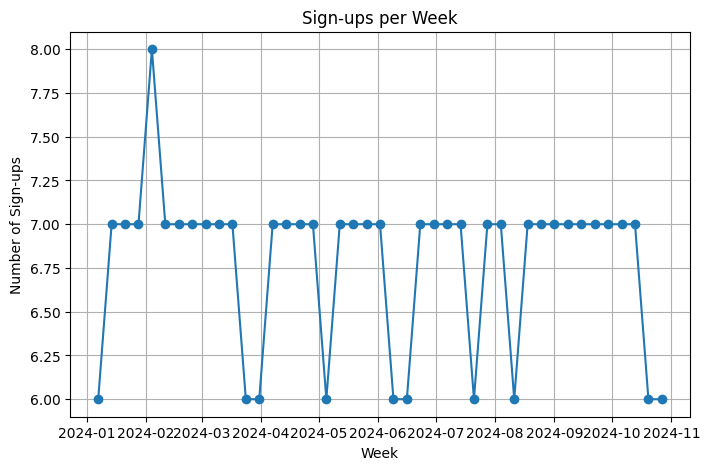

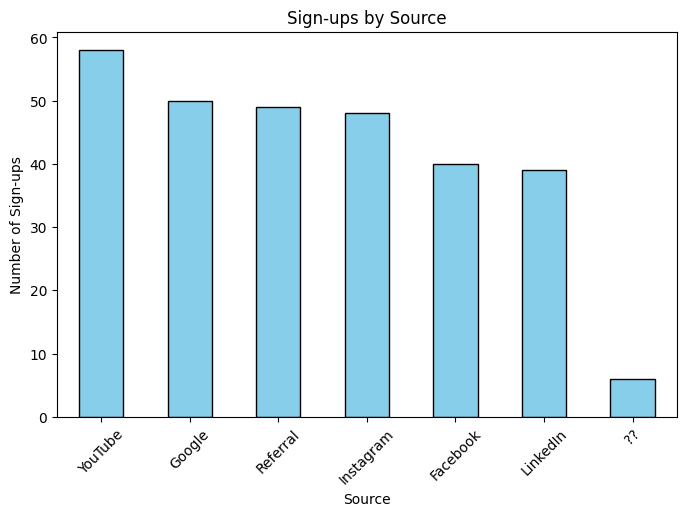

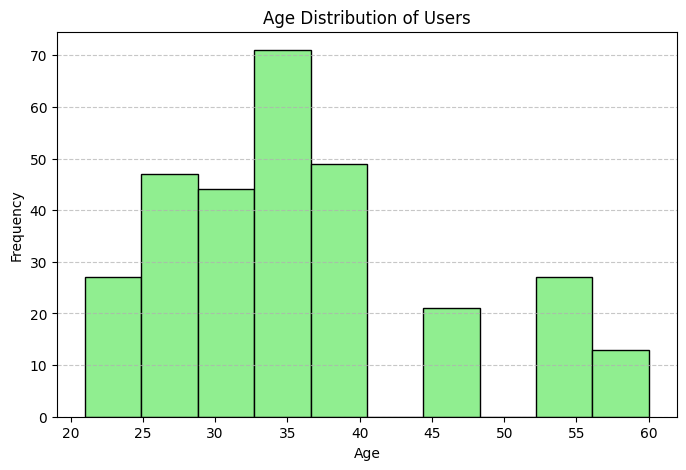

In [ ]:
# 1. Line chart: Sign-ups per week
# -----------------------------
df["signup_date"] = pd.to_datetime(df["signup_date"], errors="coerce")

signups_per_week = (
    df.set_index("signup_date")
    .resample("W")["customer_id"]
    .count()
)

plt.figure(figsize=(8,5))
plt.plot(signups_per_week.index, signups_per_week.values, marker="o")
plt.title("Sign-ups per Week")
plt.xlabel("Week")
plt.ylabel("Number of Sign-ups")
plt.grid(True)
plt.show()

# -----------------------------
# 2. Bar chart: Sign-ups by source
# -----------------------------
signups_by_source = df["source"].value_counts()

plt.figure(figsize=(8,5))
signups_by_source.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Sign-ups by Source")
plt.xlabel("Source")
plt.ylabel("Number of Sign-ups")
plt.xticks(rotation=45)
plt.show()

# -----------------------------
# 3. Histogram: Age distribution
# -----------------------------
df["age"] = pd.to_numeric(df["age"], errors="coerce")

plt.figure(figsize=(8,5))
plt.hist(df["age"].dropna(), bins=10, edgecolor="black", color="lightgreen")
plt.title("Age Distribution of Users")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()